In [1]:
import numpy as np
from functools import partial
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

import elfi
import outbreak4elfi

# Using ABC/BOLFI to infer the basic reproduction number R0 for the Ebola virus

### First with some synthetic data

In [2]:
R0_true = np.array([2.1])
seed = np.random.RandomState().get_state()[1][0]
data = outbreak4elfi.simulateR0(R0_true, 1, seed)
print(data)

[[    0     0     1     4     4     7     8    10    18    31    55    83
    127   197   302   474   742  1158  1832  2858  4459  6870 10640 16381
  25247 38759     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]


Setup external simulator and summary statistic

In [3]:
def simulator(R0, batch_size=1, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState()
    output = outbreak4elfi.simulateR0(R0, batch_size, random_state.get_state()[1][0])
    return output

Define appropriate summary statistic

In [4]:
# ratio of consequtive values
def _conseq_ratio1d(x, lag):  # single row
    inds = np.where(x > 0, np.arange(len(x)), np.nan)
    ind1 = max(int(np.nanmin(inds)) + 2, 3)  # first non-null + skip some initial
    ind2 = int(np.nanmax(inds)) + 1  # last non-null +1
    view1 = x[ind1:ind2-lag]
    view2 = x[ind1+lag:ind2]
    ratio = np.mean(view2 / view1)
    return ratio
    
def conseq_ratio(x, lag=1):
    cr1d = partial(_conseq_ratio1d, lag=lag)
    return np.apply_along_axis(cr1d, axis=1, arr=x)

Setup ELFI

In [5]:
m = elfi.new_model()
R0 = elfi.Prior('truncnorm', -1.3, 4.6, 1.7, 0.5)  # [1.05, 4]
sim = elfi.Simulator(simulator, R0, observed=data)
s1 = elfi.Summary(conseq_ratio, sim, 2)
d = elfi.Distance('euclidean', s1)
log_d = elfi.Operation(np.log, d)

Setup BOLFI and fit the GP

In [6]:
%%time
bolfi = elfi.BOLFI(log_d, bounds={'R0': [1.05, 4]}, acq_noise_var=0.1)
bolfi.fit(100)

CPU times: user 1min 14s, sys: 200 ms, total: 1min 14s
Wall time: 1min


 /usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


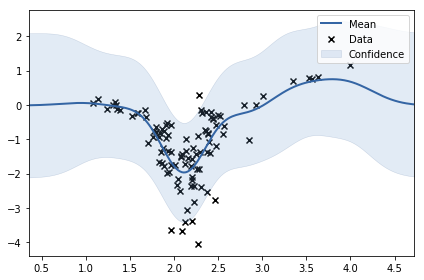

In [7]:
bolfi.target_model._gp.plot()

Sample the posterior using MCMC

In [8]:
%%time
res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
R0 1275.98374969 0.99979823465
CPU times: user 31.7 s, sys: 20 ms, total: 31.7 s
Wall time: 31.4 s


In [9]:
res

Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -1.97
Sample means: R0: 2.07

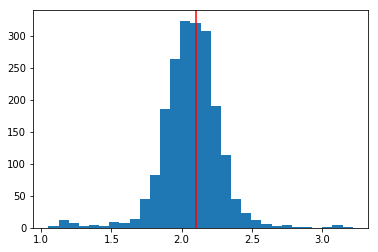

In [10]:
plt.hist(res.samples['R0'], bins=30);
plt.axvline(R0_true, color='red');

Looks good!

## Now with real data

Using data from supplement 2 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4235004/

In [11]:
# data = pd.read_excel('NIHMS60898-supplement-Supplement2.xlsx', sheet_name=1)

The data selected here: median cumulative count for confirmed, probable and suspected cases, derived using the renewal method using a serial interval 15.3 days and the line list database. 

### Country: Guinea

In [12]:
data = np.array([[487, 515, 555, 612, 694, 810, 976, 1215, 1555, 2042, 2738, 3727, 5153, 7202, 10122, 14272, 20213, 28752]])

Update observed data in ELFI and rerun inference

In [13]:
m.observed['sim'] = data

In [14]:
%%time
bolfi = elfi.BOLFI(log_d, bounds={'R0': [1.05, 4]}, acq_noise_var=0.1)
bolfi.fit(100)

CPU times: user 1min 11s, sys: 230 ms, total: 1min 12s
Wall time: 1min


 /usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


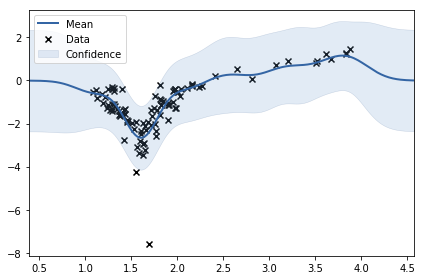

In [15]:
bolfi.target_model._gp.plot()

In [16]:
%%time
res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
R0 1119.3489024 1.00116773715
CPU times: user 26.9 s, sys: 30 ms, total: 26.9 s
Wall time: 26.8 s


Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -2.66
Sample means: R0: 1.6



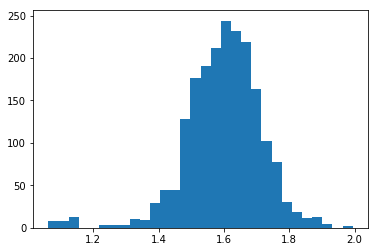

In [17]:
print(res)
plt.hist(res.samples['R0'], bins=30);

Team WER: 1.71 (95% CI, 1.44 to 2.01)

### Country: Liberia

In [18]:
data = np.array([[491, 664, 876, 1134, 1452, 1838, 2310, 2888, 3590, 4452, 5504, 6793, 8370, 10303, 12668, 15555, 19082, 23389]])
m.observed['sim'] = data

In [19]:
%%time
bolfi = elfi.BOLFI(log_d, bounds={'R0': [1.05, 4]}, acq_noise_var=0.1)
bolfi.fit(100)

CPU times: user 1min 3s, sys: 190 ms, total: 1min 3s
Wall time: 51.8 s


 /usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


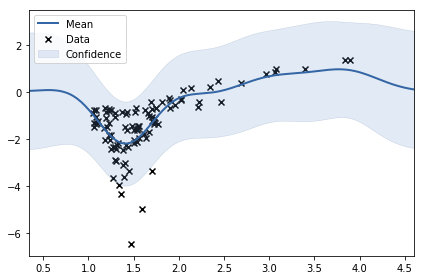

In [20]:
bolfi.target_model._gp.plot()

In [21]:
%%time
res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
R0 598.093307944 1.01263815255
CPU times: user 30.1 s, sys: 10 ms, total: 30.1 s
Wall time: 29.9 s


Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -2.2
Sample means: R0: 1.49



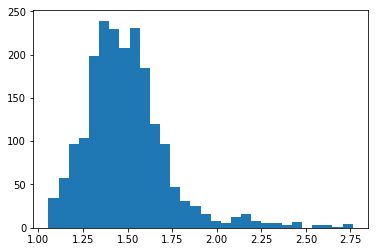

In [22]:
print(res)
plt.hist(res.samples['R0'], bins=30);

Team WER: 1.83 (95% CI, 1.72 to 1.94)

### Country: Sierra Leone

In [23]:
data = np.array([[587, 721, 870, 1035, 1219, 1422, 1648, 1900, 2182, 2494, 2842, 3228, 3656, 4128, 4658, 5244, 5898, 6624]])
m.observed['sim'] = data

In [24]:
%%time
bolfi = elfi.BOLFI(log_d, bounds={'R0': [1.05, 4]}, acq_noise_var=0.1)
bolfi.fit(100)

CPU times: user 49 s, sys: 160 ms, total: 49.2 s
Wall time: 41.8 s


 /usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


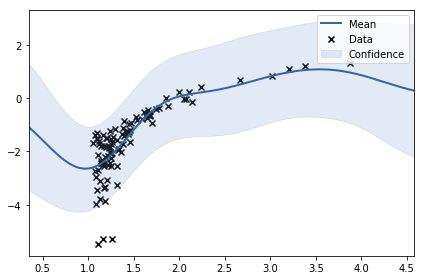

In [25]:
bolfi.target_model._gp.plot()

In [26]:
%%time
res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
R0 439.919775943 1.00410230735
CPU times: user 1min 20s, sys: 60 ms, total: 1min 20s
Wall time: 1min 20s


Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -2.6
Sample means: R0: 1.24



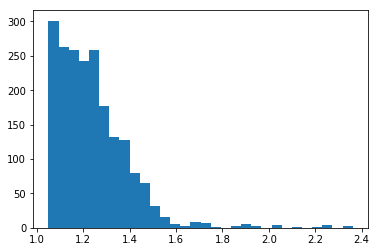

In [27]:
print(res)
plt.hist(res.samples['R0'], bins=30);

Team WER: 2.02 (95% CI, 1.79 to 2.26)

(Yes, something clearly wrong here...)

### All countries combined

In [28]:
data = np.array([[1565, 1900, 2301, 2781, 3365, 4071, 4935, 6003, 7327, 8988, 11084, 13748, 17178, 21632, 27447, 35070, 45192, 58764]])
m.observed['sim'] = data

In [29]:
%%time
bolfi = elfi.BOLFI(log_d, bounds={'R0': [1.05, 4]}, acq_noise_var=0.1)
bolfi.fit(100)

CPU times: user 1min 9s, sys: 190 ms, total: 1min 9s
Wall time: 55.9 s


 /usr/lib/python3/dist-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


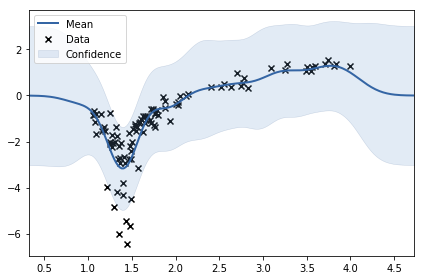

In [30]:
bolfi.target_model._gp.plot()

In [31]:
%%time
res = bolfi.sample(1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
R0 896.010288988 1.00345996815
CPU times: user 28.1 s, sys: 0 ns, total: 28.1 s
Wall time: 27.9 s


Method: BOLFI
Number of samples: 2000
Number of simulations: 100
Threshold: -3.17
Sample means: R0: 1.41



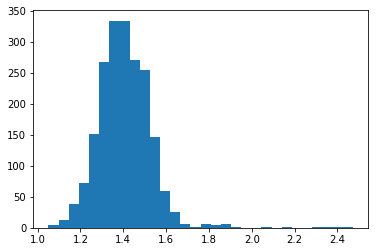

In [32]:
print(res)
plt.hist(res.samples['R0'], bins=30);